In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import os
import zipfile
from tensorflow.keras import layers
from tqdm.notebook import tqdm

# Download GloVe embeddings (6B tokens, 100d)
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Done.")
else:
    print("GloVe embeddings already present.")

--2025-12-22 16:09:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-22 16:09:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-22 16:09:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Data Pre-Processing

In [2]:
# --- 1. Define Paths ---
csv_path = "/content/Shakespeare_data.csv"
txt_path = "/content/alllines.txt"

# --- 2. Load & Clean Data ---
texts = []

# Load CSV
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    texts.extend(df["PlayerLine"].dropna().tolist())

# Load TXT
if os.path.exists(txt_path):
    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        texts.extend(f.readlines())

def clean_text(t):
    t = t.lower()
    # Remove speaker names if present (heuristic)
    if ":" in t and len(t.split(":", 1)[0]) < 20:
        t = t.split(":", 1)[1]
    t = re.sub(r"[^a-z0-9\s,.!?]", "", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

cleaned_texts = [clean_text(t) for t in texts if len(t.split()) > 5]
unique_texts = list(set(cleaned_texts))
print(f"Total unique samples: {len(unique_texts)}")

# --- 3. Add Start/End Tokens for Teacher Forcing ---
formatted_texts = [f"start_token {t} end_token" for t in unique_texts]

# --- 4. Vectorization ---
VOCAB_SIZE = 20000
SEQ_LEN = 35  # Max length of actual sentence

vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN + 1, # +1 to accommodate the shift
    standardize=None
)
vectorizer.adapt(formatted_texts)
vocab = vectorizer.get_vocabulary()

# --- 5. Create Dataset with Shifted Inputs ---
def prepare_batch(text):
    seq = vectorizer(text)

    # Encoder Input: Full sequence (can be same as decoder input or full)
    enc_in = seq[:-1]

    # Decoder Input: [START, w1, w2, ...] (Dropping last token)
    dec_in = seq[:-1]

    # Target: [w1, w2, ..., END] (Dropping first token)
    target = seq[1:]

    return (enc_in, dec_in), target

dataset = tf.data.Dataset.from_tensor_slices(formatted_texts)
dataset = dataset.map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(4096).batch(64, drop_remainder=True)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Total unique samples: 88053


## **loading embedding**

In [3]:
def load_glove_embeddings(vocab, embed_dim=100):
    embeddings_index = {}
    with open(f"glove.6B.{embed_dim}d.txt", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    vocab_list = vocab
    num_tokens = len(vocab_list)
    embedding_matrix = np.zeros((num_tokens, embed_dim))

    hits = 0
    misses = 0

    for i, word in enumerate(vocab_list):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    print(f"Converted {hits} words ({misses} misses)")
    return embedding_matrix

EMBED_DIM = 100
embedding_matrix = load_glove_embeddings(vocab, EMBED_DIM)

Converted 9598 words (10402 misses)


# **Model Building**

In [4]:
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :].astype(np.float32)
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[None, ...], tf.float32)

class TextVAE(tf.keras.Model):
    def __init__(self, vocab_size, seq_len, latent_dim, embed_dim, embedding_matrix):
        super().__init__()
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # 1. Unfrozen Embeddings (Trainable=True)
        self.embedding = layers.Embedding(
            vocab_size,
            embed_dim,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=True
        )

        # 2. High-Capacity Encoder
        self.encoder_lstm = layers.Bidirectional(layers.LSTM(256))
        self.encoder_dense = layers.Dense(latent_dim * 2)

        # 3. Decoder
        self.latent_projection = layers.Dense(seq_len * embed_dim)
        self.pos_encoding = positional_encoding(seq_len, embed_dim)

        # Transformer Blocks
        self.decoder_layers = [
            layers.MultiHeadAttention(num_heads=4, key_dim=embed_dim) for _ in range(2)
        ]
        self.ffn_layers = [
            tf.keras.Sequential([
                layers.Dense(512, activation="relu"),
                layers.Dense(embed_dim)
            ]) for _ in range(2)
        ]
        self.layernorm1 = [layers.LayerNormalization(epsilon=1e-6) for _ in range(2)]
        self.layernorm2 = [layers.LayerNormalization(epsilon=1e-6) for _ in range(2)]

        self.output_layer = layers.Dense(vocab_size)

    def encode(self, x):
        x = self.embedding(x)
        x = self.encoder_lstm(x)
        mean, logvar = tf.split(self.encoder_dense(x), 2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(0.5 * logvar) + mean

    def decode(self, z, x, training=False, word_dropout_rate=0.0):
        # Word Dropout Logic
        if training and word_dropout_rate > 0:
            rand = tf.random.uniform(shape=tf.shape(x))
            drop_mask = tf.cast(rand > word_dropout_rate, x.dtype)
            x = x * drop_mask + 1 * (1 - drop_mask) # 1 is [UNK]

        x_emb = self.embedding(x)
        x_emb += self.pos_encoding

        # Inject Latent Z
        z_proj = self.latent_projection(z)
        z_proj = tf.reshape(z_proj, (-1, self.seq_len, self.embed_dim))
        h = x_emb + z_proj

        # Transformer Loop
        mask = tf.linalg.band_part(tf.ones((self.seq_len, self.seq_len)), -1, 0)

        for i in range(len(self.decoder_layers)):
            attn_out = self.decoder_layers[i](h, h, attention_mask=mask)
            h = self.layernorm1[i](h + attn_out)
            ffn_out = self.ffn_layers[i](h)
            h = self.layernorm2[i](h + ffn_out)

        return self.output_layer(h)

# Initialize
latent_dim = 128
MODEL_SEQ_LEN = SEQ_LEN
model = TextVAE(VOCAB_SIZE, MODEL_SEQ_LEN, latent_dim, EMBED_DIM, embedding_matrix)

In [5]:
import tensorflow as tf

# --- 1. Safe Scheduler Calculation ---
try:
    # If dataset is valid, use its length
    steps_per_epoch = len(dataset)
    if steps_per_epoch == 0:
        print("⚠️ Warning: Dataset length is 0. Defaulting to 1000 steps.")
        steps_per_epoch = 1000
except:
    print("⚠️ Warning: Dataset not found. Defaulting to 1000 steps.")
    steps_per_epoch = 1000

decay_steps = 30 * steps_per_epoch  # 30 Epochs

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=decay_steps,
    alpha=0.1
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
print("✅ Optimizer ready.")

✅ Optimizer ready.


# **Training**

In [6]:
# Scheduler: High start -> smooth decay
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=30 * len(dataset),
    alpha=0.1
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

# --- 3. TRAINING LOOP ---
EPOCHS = 30
KL_WARMUP = 5

@tf.function
def train_step(inputs, target, beta, word_dropout):
    enc_in, dec_in = inputs

    with tf.GradientTape() as tape:
        mean, logvar = model.encode(enc_in)
        z = model.reparameterize(mean, logvar)

        logits = model.decode(z, dec_in, training=True, word_dropout_rate=word_dropout)

        recon_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                target, logits, from_logits=True
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
        )
        # Hinge loss
        kl_loss_clipped = tf.maximum(kl_loss, 0.1)

        total_loss = recon_loss + (beta * kl_loss_clipped)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, recon_loss, kl_loss

    print(f"Starting Training on {len(dataset)} batches...")

for epoch in range(EPOCHS):
    # KL Annealing
    if epoch < KL_WARMUP:
        BETA = (epoch / KL_WARMUP) * 0.5
    else:
        BETA = 0.5

    epoch_loss = 0.0
    epoch_recon = 0.0
    epoch_kl = 0.0
    steps = 0

    # Progress Bar
    progress = tqdm(dataset, desc=f"Epoch {epoch+1}", leave=False)

    for batch in progress:
        # UNPACKING LOGIC:
        # Since we just rebuilt the dataset, we KNOW it returns ((Enc, Dec), Target)
        # We can unpack it safely now.
        (enc_in, dec_in), target = batch

        # Train Step
        loss, recon, kl = train_step((enc_in, dec_in), target, BETA, word_dropout=0.3)

        epoch_loss += loss
        epoch_recon += recon
        epoch_kl += kl
        steps += 1

        progress.set_postfix({
            "loss": f"{loss:.3f}",
            "recon": f"{recon:.3f}",
            "kl": f"{kl:.3f}"
        })

    # Epoch Summary
    avg_loss = epoch_loss / steps if steps > 0 else 0
    avg_recon = epoch_recon / steps if steps > 0 else 0
    avg_kl = epoch_kl / steps if steps > 0 else 0

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

print("Training Complete!")

Epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.5026 | Recon: 1.5026 | KL: 379.8035


Epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.7240 | Recon: 1.5700 | KL: 1.5290


Epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.5290 | Recon: 1.5088 | KL: 0.0863


Epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.5086 | Recon: 1.4783 | KL: 0.0849


Epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 5 | Loss: 1.4947 | Recon: 1.4545 | KL: 0.0823


Epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 6 | Loss: 1.4829 | Recon: 1.4328 | KL: 0.0820


Epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 7 | Loss: 1.4631 | Recon: 1.4130 | KL: 0.0826


Epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 8 | Loss: 1.4454 | Recon: 1.3953 | KL: 0.0852


Epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 9 | Loss: 1.4289 | Recon: 1.3788 | KL: 0.0854


Epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 10 | Loss: 1.4140 | Recon: 1.3639 | KL: 0.0856


Epoch 11:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 11 | Loss: 1.3990 | Recon: 1.3489 | KL: 0.0851


Epoch 12:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 12 | Loss: 1.3854 | Recon: 1.3353 | KL: 0.0862


Epoch 13:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 13 | Loss: 1.3722 | Recon: 1.3221 | KL: 0.0861


Epoch 14:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 14 | Loss: 1.3594 | Recon: 1.3093 | KL: 0.0862


Epoch 15:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 15 | Loss: 1.3471 | Recon: 1.2970 | KL: 0.0869


Epoch 16:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 16 | Loss: 1.3350 | Recon: 1.2849 | KL: 0.0875


Epoch 17:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 17 | Loss: 1.3233 | Recon: 1.2732 | KL: 0.0865


Epoch 18:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 18 | Loss: 1.3130 | Recon: 1.2629 | KL: 0.0879


Epoch 19:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 19 | Loss: 1.3018 | Recon: 1.2517 | KL: 0.0877


Epoch 20:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 20 | Loss: 1.2928 | Recon: 1.2427 | KL: 0.0874


Epoch 21:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 21 | Loss: 1.2835 | Recon: 1.2334 | KL: 0.0873


Epoch 22:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 22 | Loss: 1.2755 | Recon: 1.2254 | KL: 0.0885


Epoch 23:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 23 | Loss: 1.2682 | Recon: 1.2181 | KL: 0.0881


Epoch 24:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 24 | Loss: 1.2611 | Recon: 1.2110 | KL: 0.0892


Epoch 25:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 25 | Loss: 1.2550 | Recon: 1.2050 | KL: 0.0884


Epoch 26:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 26 | Loss: 1.2500 | Recon: 1.2000 | KL: 0.0886


Epoch 27:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 27 | Loss: 1.2449 | Recon: 1.1948 | KL: 0.0885


Epoch 28:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 28 | Loss: 1.2423 | Recon: 1.1922 | KL: 0.0891


Epoch 29:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 29 | Loss: 1.2389 | Recon: 1.1888 | KL: 0.0894


Epoch 30:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 30 | Loss: 1.2363 | Recon: 1.1862 | KL: 0.0889
Training Complete!


# **Evaluation**


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

def evaluate_model(model, dataset, max_batches=50):
    y_true = []
    y_pred = []

    print(f"Evaluating on {max_batches} batches...")

    for i, batch in enumerate(dataset):
        if i >= max_batches:
            break

        # --- FIX: Unpack the tuple ((enc_in, dec_in), target) ---
        (enc_in, dec_in), target = batch

        # 1. Forward Pass
        mean, logvar = model.encode(enc_in)
        z = model.reparameterize(mean, logvar)

        # training=False ensures NO word dropout during evaluation
        logits = model.decode(z, dec_in, training=False)

        # 2. Get Predictions (Token IDs)
        # shape: (batch_size, seq_len)
        predictions = tf.argmax(logits, axis=-1)

        # 3. Flatten and Store
        # We flatten because sklearn expects 1D arrays of labels
        y_true.extend(target.numpy().flatten())
        y_pred.extend(predictions.numpy().flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 4. Calculate Metrics
    # Filter out padding (0) to strictly measure text performance
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    acc = accuracy_score(y_true_filtered, y_pred_filtered)

    # Macro average treats all classes equally (good for checking diversity)
    prec = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
    rec = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)

    print("\n=== Model Performance ===")
    print(f"Token-Level Accuracy:  {acc:.4f}")
    print(f"Macro Precision:       {prec:.4f}")
    print(f"Macro Recall:          {rec:.4f}")

    return y_true_filtered, y_pred_filtered

# Run Evaluation
y_true_eval, y_pred_eval = evaluate_model(model, dataset)

Evaluating on 50 batches...

=== Model Performance ===
Token-Level Accuracy:  0.2793
Macro Precision:       0.1948
Macro Recall:          0.1809


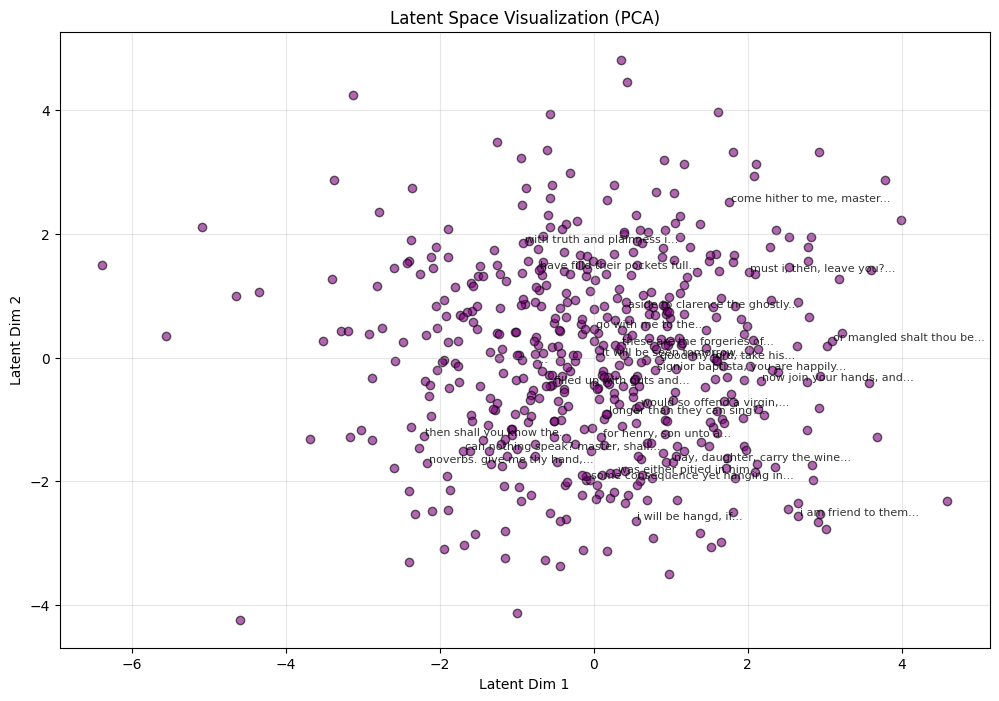

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Encode a subset of the data
# Take first 500 sentences for visualization
subset_texts = unique_texts[:500]
subset_vecs = vectorizer(np.array(subset_texts))

# Get Latent Z for these sentences
mean, logvar = model.encode(subset_vecs)
z_subset = model.reparameterize(mean, logvar)

# 2. Reduce to 2D using PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_subset.numpy())

# 3. Plot
plt.figure(figsize=(12, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.6, c='purple', edgecolors='k')

# 4. Annotate a few points to see what they are
for i in range(0, 500, 20): # Annotate every 20th sentence
    text_snippet = " ".join(subset_texts[i].split()[:5]) + "..."
    plt.text(z_2d[i, 0]+0.02, z_2d[i, 1]+0.02, text_snippet, fontsize=8, alpha=0.8)

plt.title("Latent Space Visualization (PCA)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
vocab = vectorizer.get_vocabulary()
id_to_token = dict(enumerate(vocab))

def tokens_to_text(tokens):
    # Convert IDs to words
    words = [id_to_token.get(t, "") for t in tokens if t > 1] # Ignore PAD(0) and UNK(1)

    # Rejoin string
    text = " ".join(words)

    # --- CLEANUP LOGIC HERE ---
    # Removes the technical tokens so you just see the poetry
    text = text.replace("start_token", "").replace("end_token", "")

    return text.strip()

def encode_text(model, text):
    text = f"start_token {text} end_token"
    tokens = vectorizer([text])
    enc_in = tokens[:, :-1]
    mean, logvar = model.encode(enc_in)
    z = model.reparameterize(mean, logvar)
    return z

def slerp(val, low, high):
    low_norm = low / tf.norm(low)
    high_norm = high / tf.norm(high)
    omega = tf.acos(tf.clip_by_value(tf.tensordot(low_norm, high_norm, axes=1), -1, 1))
    so = tf.sin(omega)
    if so == 0: return (1.0 - val) * low + val * high
    return (tf.sin((1.0 - val) * omega) / so) * low + (tf.sin(val * omega) / so) * high

def generate_from_z_stabilized(model, z, max_len=20):
    try:
        start_idx = list(vocab).index("start_token")
    except:
        start_idx = 1

    current_seq = [start_idx]
    generated_ids = []

    for _ in range(max_len):
        seq_input = current_seq[-SEQ_LEN:]
        if len(seq_input) < SEQ_LEN:
            seq_input = [0] * (SEQ_LEN - len(seq_input)) + seq_input

        x_input = tf.convert_to_tensor([seq_input], dtype=tf.int64)

        logits = model.decode(z, x_input, training=False)
        next_token_logits = logits[:, SEQ_LEN-1, :]

        # Block PAD/UNK
        next_token_logits = tf.tensor_scatter_nd_update(
            next_token_logits, [[0, 0], [0, 1]], [-1e9, -1e9]
        )

        # Strict Anti-Repetition
        if len(generated_ids) > 0:
            last_token = generated_ids[-1]
            next_token_logits = tf.tensor_scatter_nd_update(
                next_token_logits, [[0, last_token]], [-1e9]
            )

        # Low Temp & Top-K
        next_token_logits = next_token_logits / 0.6
        values, indices = tf.math.top_k(next_token_logits, k=20)

        sampled_index = tf.random.categorical(values, num_samples=1)[0, 0]
        next_token_id = indices[0, sampled_index].numpy()

        # Logic to stop generation internally if needed,
        # but we let it run to max_len or break on end_token match
        try:
            if next_token_id == list(vocab).index("end_token"):
                break
        except:
            pass

        generated_ids.append(next_token_id)
        current_seq.append(next_token_id)

    return tokens_to_text(generated_ids)

def interpolate_sentences(model, start_text, end_text, steps=6):
    z_start = tf.squeeze(encode_text(model, start_text))
    z_end = tf.squeeze(encode_text(model, end_text))

    alphas = np.linspace(0, 1, steps)
    print(f"Morphing (SLERP): '{start_text}'  ->  '{end_text}'\n")

    for alpha in alphas:
        z_interp = slerp(alpha, z_start, z_end)
        z_interp = tf.expand_dims(z_interp, 0)
        text = generate_from_z_stabilized(model, z_interp)
        print(f"{alpha:.1f}: {text}")

In [10]:
import tensorflow as tf

# ----------------------------
# 1. Vocabulary & Helpers
# ----------------------------
vocab = vectorizer.get_vocabulary()
id_to_token = dict(enumerate(vocab))

def tokens_to_text(tokens):
    """Convert list of token IDs to string, cleaning up special tokens."""
    words = [id_to_token.get(t, "") for t in tokens if t > 1]
    text = " ".join(words)
    return text.replace("start_token", "").replace("end_token", "").strip()

def encode_text(model, text):
    """Encode text to latent vector z."""
    text = f"start_token {text} end_token"
    tokens = vectorizer([text])
    enc_in = tokens[:, :-1]
    mean, logvar = model.encode(enc_in)
    z = model.reparameterize(mean, logvar)
    return z, tokens

# ----------------------------
# 2. Optimized Top-P (Nucleus) Sampling
# ----------------------------
def top_p_sampling(logits, p=0.9):
    probs = tf.nn.softmax(logits)
    sorted_probs = tf.sort(probs, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(sorted_probs, axis=-1)

    cutoff_idx = tf.reduce_sum(tf.cast(cumulative_probs < p, tf.int32))
    cutoff_idx = tf.minimum(cutoff_idx, tf.shape(logits)[-1] - 1)
    cutoff_prob = tf.gather(sorted_probs, cutoff_idx, axis=-1)

    return tf.where(probs < cutoff_prob, tf.fill(tf.shape(logits), -1e9), logits)

# ----------------------------
# 3. Text Completion (Longer Output Settings)
# ----------------------------
def complete_text(model, prompt, max_new_tokens=60, min_len=15, temperature=0.7, top_p=0.9, seq_len=SEQ_LEN):
    # 1. Get Z and Tokens
    z, tokens_tensor = encode_text(model, prompt)
    tokens = tokens_tensor.numpy()[0].tolist()
    tokens = [t for t in tokens if t != 0] # Remove padding

    # 2. Remove 'end_token' from the prompt seed
    try:
        end_id = list(vocab).index("end_token")
        if tokens and tokens[-1] == end_id:
            tokens.pop()
    except ValueError:
        end_id = 0

    generated_count = 0

    for _ in range(max_new_tokens):
        # 3. Prepare Input with RIGHT PADDING
        current_seq = tokens[-seq_len:]
        if len(current_seq) < seq_len:
            current_seq = current_seq + [0] * (seq_len - len(current_seq))

        x_input = tf.convert_to_tensor([current_seq], dtype=tf.int64)

        # 4. Decode
        logits = model.decode(z, x_input, training=False)

        valid_len = len([t for t in current_seq if t != 0])
        pred_idx = min(valid_len - 1, seq_len - 1)
        next_logits = logits[:, pred_idx, :] / temperature

        # === Constraints ===

        # A. Force Minimum Length
        if generated_count < min_len:
            next_logits = tf.tensor_scatter_nd_update(
                next_logits, [[0, end_id], [0, 0]], [-1e9, -1e9]
            )
        else:
            next_logits = tf.tensor_scatter_nd_update(
                next_logits, [[0, 0]], [-1e9]
            )

        # B. Strict Anti-Stutter
        last_token = tokens[-1]
        next_logits = tf.tensor_scatter_nd_update(
            next_logits, [[0, last_token]], [-1e9]
        )

        # C. Soft Repetition Penalty
        recent_tokens = set(tokens[-5:])
        for t_id in recent_tokens:
            if t_id != last_token:
                next_logits = tf.tensor_scatter_nd_sub(
                    next_logits, [[0, t_id]], [2.0]
                )

        # D. Top-P Sampling
        next_logits = top_p_sampling(next_logits, p=top_p)

        # === Sample ===
        next_token_id = tf.random.categorical(next_logits, num_samples=1)[0, 0].numpy()

        if next_token_id == end_id:
            break

        tokens.append(next_token_id)
        generated_count += 1

    return tokens_to_text(tokens)

# ----------------------------
# 4. Run Tests with Extended Length
# ----------------------------
test_prompts = [
    "to be or not to be",
    "the king hath sent",
    "what light through yonder",
    "romeo where art thou"
]

print("\n=== GENERATION TESTS (Longer Sentences) ===")
for p in test_prompts:
    # Explicitly requesting 60 new tokens and at least 15 words
    generated = complete_text(model, p, max_new_tokens=60, min_len=15, temperature=0.8)
    print(f"\nPrompt: {p}")
    print(f"Result: {generated}")


=== GENERATION TESTS (Longer Sentences) ===

Prompt: to be or not to be
Result: to be or not to be it at your pleasure, as you shall have spoke, and terribly, away by her,

Prompt: the king hath sent
Result: the king hath sent him to the tower, to friar and catesby, his soldier. and, and his hand, another enter the gates of them

Prompt: what light through yonder
Result: what light through yonder rages, and the night his hay. he rages, a comes, and diomedes, terribly, in a captains and maskers

Prompt: romeo where art thou
Result: romeo where art thou that see this? the queen or no? i and thee? the crown guildford suffolk, a soothsayer thomas hastings


In [11]:
import numpy as np

# 1. SLERP (Spherical Linear Interpolation)
def slerp(val, low, high):
    """Smoothly interpolates between two Z vectors on the hypersphere."""
    low_norm = low / tf.norm(low)
    high_norm = high / tf.norm(high)
    omega = tf.acos(tf.clip_by_value(tf.tensordot(low_norm, high_norm, axes=1), -1, 1))
    so = tf.sin(omega)
    if so == 0: return (1.0 - val) * low + val * high
    return (tf.sin((1.0 - val) * omega) / so) * low + (tf.sin(val * omega) / so) * high

# 2. Generator for Z (Updated with Long-Sentence Settings)
def generate_from_z(model, z, max_len=60, min_len=15, temperature=0.7, top_p=0.9):
    try:
        start_id = list(vocab).index("start_token")
        end_id = list(vocab).index("end_token")
    except:
        start_id = 1
        end_id = 0

    current_seq = [start_id]
    generated_ids = []

    for _ in range(max_len):
        # A. Right Padding
        seq_input = current_seq[-SEQ_LEN:]
        if len(seq_input) < SEQ_LEN:
            seq_input = seq_input + [0] * (SEQ_LEN - len(seq_input))

        x_input = tf.convert_to_tensor([seq_input], dtype=tf.int64)

        # B. Decode
        logits = model.decode(z, x_input, training=False)

        valid_len = len([t for t in current_seq if t != 0])
        pred_idx = min(valid_len - 1, SEQ_LEN - 1)
        next_logits = logits[:, pred_idx, :] / temperature

        # C. Constraints

        # 1. Force Min Length
        if len(generated_ids) < min_len:
            next_logits = tf.tensor_scatter_nd_update(
                next_logits, [[0, end_id], [0, 0]], [-1e9, -1e9]
            )
        else:
            next_logits = tf.tensor_scatter_nd_update(
                next_logits, [[0, 0]], [-1e9]
            )

        # 2. Anti-Stutter
        if generated_ids:
            last_token = generated_ids[-1]
            next_logits = tf.tensor_scatter_nd_update(
                next_logits, [[0, last_token]], [-1e9]
            )

        # 3. Soft Repetition Penalty
        recent = set(generated_ids[-5:])
        for t in recent:
            if generated_ids and t != generated_ids[-1]:
                next_logits = tf.tensor_scatter_nd_sub(next_logits, [[0, t]], [2.0])

        # D. Top-P
        next_logits = top_p_sampling(next_logits, p=top_p)

        # E. Sample
        next_token_id = tf.random.categorical(next_logits, num_samples=1)[0, 0].numpy()

        if next_token_id == end_id:
            break

        generated_ids.append(next_token_id)
        current_seq.append(next_token_id)

    return tokens_to_text(generated_ids)

# 3. The Interpolation Loop
def interpolate_sentences(model, start_text, end_text, steps=6):
    z_start, _ = encode_text(model, start_text)
    z_end, _   = encode_text(model, end_text)

    z_start = tf.squeeze(z_start)
    z_end = tf.squeeze(z_end)

    alphas = np.linspace(0, 1, steps)

    print(f"Morphing: '{start_text}'  ->  '{end_text}'\n")

    for alpha in alphas:
        z_interp = slerp(alpha, z_start, z_end)
        z_interp = tf.expand_dims(z_interp, 0)

        # Use increased length settings
        text = generate_from_z(model, z_interp, max_len=60, min_len=15)
        print(f"{alpha:.1f}: {text}")

# Run the Morphing Test
interpolate_sentences(model, "the king hath sent", "romeo where art thou", steps=6)

Morphing: 'the king hath sent'  ->  'romeo where art thou'

0.0: and here with us to the king he him here to you. they again, and a soldiers
0.2: if it be so, thou must be gone to thee. come, lets away. go away,
0.4: to make a fool of her to my heart. and go with her. i
0.6: to polonius will he know the other sort of it. but i was to him.
0.8: to the of his surveyor, ha? this is a man of soldier. and his
1.0: but wherefore am i entreated her hither, sir offers to the house. and masked then


Encoding prompts into 128D latent space...
Running t-SNE reduction (128D -> 2D)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plot generated successfully.


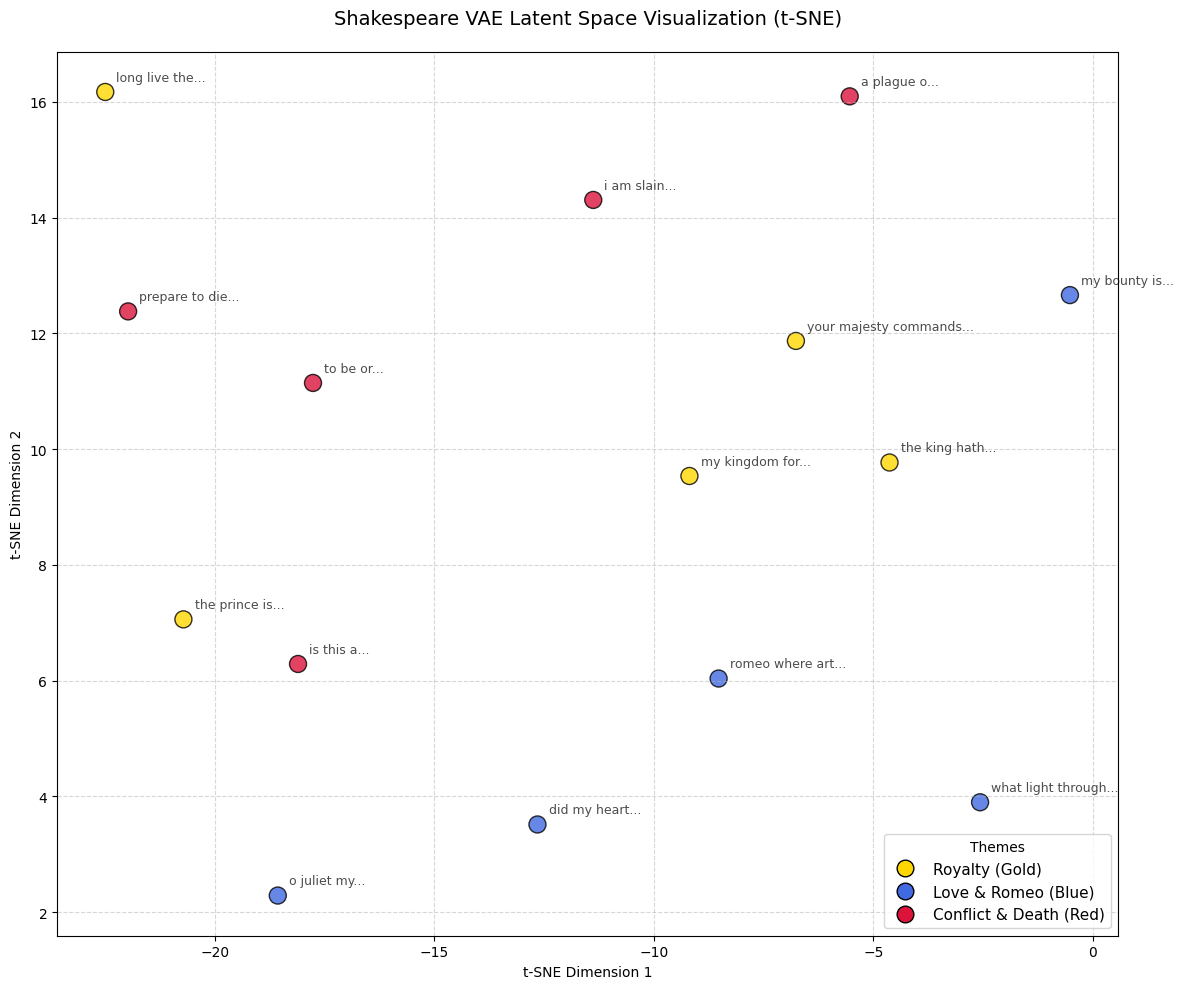

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.lines import Line2D

# --- 1. Define Thematic Prompts ---
# We pick distinct themes to see if the VAE separates them in its "brain"
themes = {
    "Royalty (Gold)": [
        "the king hath sent",
        "my kingdom for a horse",
        "long live the king",
        "your majesty commands it",
        "the prince is angry"
    ],
    "Love & Romeo (Blue)": [
        "romeo where art thou",
        "what light through yonder window breaks",
        "did my heart love till now",
        "o juliet my sweet",
        "my bounty is as boundless as the sea"
    ],
    "Conflict & Death (Red)": [
        "to be or not to be",
        "a plague o both your houses",
        "is this a dagger which i see",
        "i am slain",
        "prepare to die"
    ]
}

# --- 2. Encode Prompts into Latent Space (Z) ---
z_vectors = []
point_labels = []
point_colors = []
theme_color_map = {
    "Royalty (Gold)": "gold",
    "Love & Romeo (Blue)": "royalblue",
    "Conflict & Death (Red)": "crimson"
}

print("Encoding prompts into 128D latent space...")
for theme, prompts in themes.items():
    for p in prompts:
        # Use our existing encode function to get Z
        z_tensor, _ = encode_text(model, p)
        # Flatten tensor to numpy array for t-SNE
        z_vec = z_tensor.numpy().flatten()

        z_vectors.append(z_vec)
        point_labels.append(p)
        point_colors.append(theme_color_map[theme])

z_matrix = np.array(z_vectors)

# --- 3. Dimensionality Reduction (t-SNE) ---
# Squash 128 dimensions down to 2 for plotting
print("Running t-SNE reduction (128D -> 2D)...")
# Perplexity must be < number of samples (we have 15)
tsne = TSNE(n_components=2, perplexity=5, random_state=42, n_iter=2000, init='pca')
z_2d = tsne.fit_transform(z_matrix)

# --- 4. Plotting ---
plt.figure(figsize=(12, 10))

# Plot the points
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=point_colors, s=150, edgecolors='k', alpha=0.8)

for i, label in enumerate(point_labels):
    # Annotate only a few words to keep it clean
    short_label = " ".join(label.split()[:3]) + "..."
    plt.annotate(short_label, (z_2d[i, 0], z_2d[i, 1]),
                 xytext=(8, 8), textcoords='offset points', fontsize=9, alpha=0.7)

# Create Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k,
                          markerfacecolor=v, markersize=12, markeredgecolor='k')
                   for k, v in theme_color_map.items()]
plt.legend(handles=legend_elements, loc='best', title="Themes", fontsize=11)

plt.title("Shakespeare VAE Latent Space Visualization (t-SNE)", fontsize=14, pad=20)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

print("Plot generated successfully.")
plt.show()

Analyzing prompt: 'the king hath sent'...
  Temp 0.2 | Diversity: 0.63 | Confidence: 0.71
  Temp 0.5 | Diversity: 0.97 | Confidence: 0.45
  Temp 0.7 | Diversity: 0.91 | Confidence: 0.33
  Temp 1.0 | Diversity: 1.00 | Confidence: 0.12
  Temp 1.2 | Diversity: 1.00 | Confidence: 0.16
  Temp 1.5 | Diversity: 1.00 | Confidence: 0.06


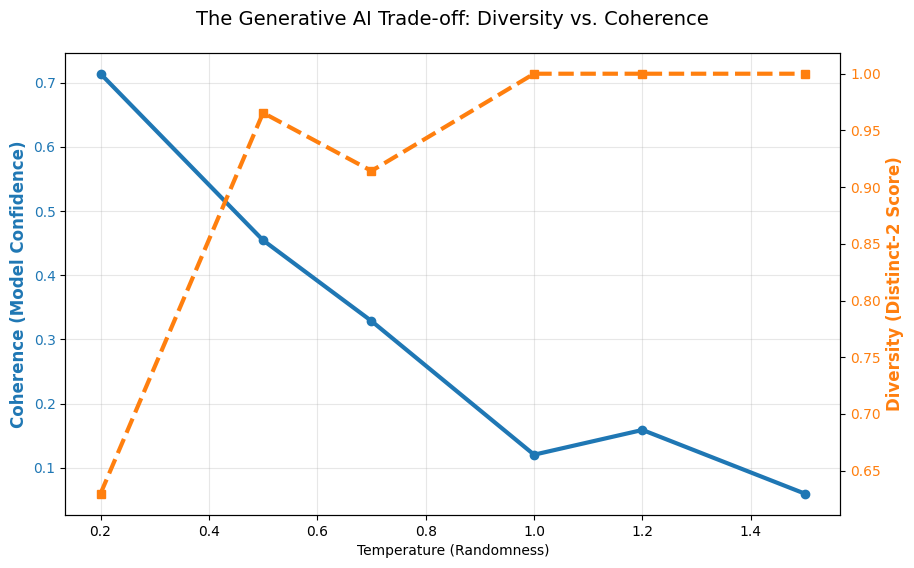

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --- 1. Define Metric Functions ---

def get_distinct_n(corpus, n=2):
    """Calculates Distinct-N: Ratio of unique n-grams to total n-grams."""
    if not corpus: return 0.0

    bigrams = []
    for sentence in corpus:
        tokens = sentence.split()
        if len(tokens) < n: continue
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i+n])
            bigrams.append(ngram)

    if len(bigrams) == 0: return 0.0
    return len(set(bigrams)) / len(bigrams)

def analyze_generation(model, prompt, temps):
    """Generates text at different temps and tracks metrics."""
    diversity_scores = []
    coherence_scores = []

    z, _ = encode_text(model, prompt)

    print(f"Analyzing prompt: '{prompt}'...")

    for temp in temps:
        generated_sentences = []
        token_probs = []

        # Generate batch of 5 sentences per temp to get average
        for _ in range(5):
            # --- Inline Generation Logic to Capture Logits ---
            # (Simplified version of your generator for analysis)
            current_seq = [list(vocab).index("start_token")]
            seq_probs = []

            for _ in range(20): # Short length for speed
                seq_in = current_seq[-SEQ_LEN:]
                if len(seq_in) < SEQ_LEN: seq_in = seq_in + [0]*(SEQ_LEN - len(seq_in))
                x_in = tf.convert_to_tensor([seq_in], dtype=tf.int64)

                logits = model.decode(z, x_in, training=False)
                next_logits = logits[:, min(len(current_seq)-1, SEQ_LEN-1), :] / temp

                # Softmax to get probabilities
                probs = tf.nn.softmax(next_logits)

                # Sample
                next_id = tf.random.categorical(next_logits, num_samples=1)[0, 0].numpy()

                # Track probability of the CHOSEN token (Coherence Proxy)
                chosen_prob = probs[0, next_id].numpy()
                seq_probs.append(chosen_prob)

                if next_id == list(vocab).index("end_token"): break
                current_seq.append(next_id)

            text = tokens_to_text(current_seq)
            generated_sentences.append(text)
            token_probs.append(np.mean(seq_probs))

        # Calc Metrics for this Temp
        div_score = get_distinct_n(generated_sentences, n=2)
        coh_score = np.mean(token_probs)

        diversity_scores.append(div_score)
        coherence_scores.append(coh_score)
        print(f"  Temp {temp:.1f} | Diversity: {div_score:.2f} | Confidence: {coh_score:.2f}")

    return diversity_scores, coherence_scores

# --- 2. Run Analysis ---
temperatures = [0.2, 0.5, 0.7, 1.0, 1.2, 1.5]
prompt = "the king hath sent"

divs, cohs = analyze_generation(model, prompt, temperatures)

# --- 3. Plot the Trade-off ---
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Temperature (Randomness)')
ax1.set_ylabel('Coherence (Model Confidence)', color=color, fontsize=12, fontweight='bold')
ax1.plot(temperatures, cohs, color=color, marker='o', linewidth=3, label='Coherence')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Diversity (Distinct-2 Score)', color=color, fontsize=12, fontweight='bold')
ax2.plot(temperatures, divs, color=color, marker='s', linestyle='--', linewidth=3, label='Diversity')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('The Generative AI Trade-off: Diversity vs. Coherence', fontsize=14, pad=20)
plt.show()

In [15]:
import json
import numpy as np

model.build(input_shape=(None, SEQ_LEN))

# 1. Save Model Weights
model.save_weights("shakespeare_vae.weights.h5")
print("✅ Model weights saved to 'shakespeare_vae.weights.h5'")

# 2. Save Vocabulary (Crucial for decoding)
vocab_list = vectorizer.get_vocabulary()

with open("vocab.json", "w") as f:
    json.dump(vocab_list, f)
print("✅ Vocabulary saved to 'vocab.json'")

config = {
    "vocab_size": len(vocab_list),
    "seq_len": SEQ_LEN,
    "latent_dim": 32,
    "embed_dim": 256,
    "ff_dim": 512
}
with open("config.json", "w") as f:
    json.dump(config, f)
print("✅ Config saved to 'config.json'")

✅ Model weights saved to 'shakespeare_vae.weights.h5'
✅ Vocabulary saved to 'vocab.json'
✅ Config saved to 'config.json'
